In [2]:

from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# open csv

In [3]:
# open preprocessed data
df = pd.read_csv('../data/processed_reviews.csv')
# select subcategory to analyze
subcategory = 'BODY CARE BODY LOTION'
# subcategory = 'SPRAY CLEANERS BLEACH CLEANERS'
label = "lotion"
df = df[df['subcategory'] == subcategory]
print(df.shape)
df.head()

(20281, 10)


,brand,product_title,proxy_date,retailer,category,subcategory,review_text,star_rating,topic,brand_type
210565,Palmer's,Palmer's Cocoa Butter Formula Daily Skin Thera...,2024-07-01,CVS,PERSONAL CARE,BODY CARE BODY LOTION,i have use this lotion for year and love it ve...,5.0,Moisturizer preference and usage habits,Competitor
210757,EOS,eos Shea Better Moisture Body Lotion - Vanilla...,2024-07-01,Target,PERSONAL CARE,BODY CARE BODY LOTION,ive be look for a new body lotion from a compa...,3.0,Positive reviews for a makeup remover (undeter...,Competitor
210829,Eucerin,Eucerin Intensive Repair Very Dry Skin Lotion ...,2024-07-01,Amazon,PERSONAL CARE,BODY CARE BODY LOTION,this lotion be a must have if you have dry ski...,5.0,Positive reviews for a makeup remover (undeter...,Competitor
210925,Medix 5.5,Medix 5.5 Retinol Body Lotion Firming Moisturi...,2024-07-01,Amazon,PERSONAL CARE,BODY CARE BODY LOTION,no retinol list on ingredient list,1.0,Positive reviews for a makeup remover (undeter...,Competitor
211032,Medix 5.5,Medix 5.5 Retinol Body Lotion Firming Moisturi...,2024-07-01,Amazon,PERSONAL CARE,BODY CARE BODY LOTION,i love this lotion lovely scent it have bright...,5.0,Positive reviews for a makeup remover (undeter...,Competitor


In [4]:
# group reviews by subcategory and make dictrionary with rating: review_text
grouped = df.groupby('star_rating').apply(lambda x: x['review_text'].tolist()).to_dict()

/var/folders/x2/lsyflj4j07jc1sb3w3hfgmjc0000gn/T/ipykernel_20548/719716116.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('star_rating').apply(lambda x: x['review_text'].tolist()).to_dict()


In [5]:
def get_number_topics(num_reviews):
    if num_reviews > 50000:
        return 20
    if num_reviews > 25000:
        return 15
    if num_reviews > 10000:
        return 10
    if num_reviews > 5000:
        return 8
    if num_reviews > 1000:
        return 6
    if num_reviews > 500:
        return 5
    if num_reviews > 100:
        return 4
    if num_reviews > 50:
        return 3
    if num_reviews > 10:
        return 2
    return 1
total_topics = get_number_topics(df.shape[0])
total_topics

10

In [6]:
def calculate_num_topics_star_rating(total_topics, star_rating, min_topics=1):
    # logarithmic weighting (smooth it out)
    weight = math.log(6 - star_rating + 1)  # Adding 1 to avoid log(0)


    # normalize weight to ensure sum of the topics is not greater than total_topics
    total_weight = sum(math.log(6 - r + 1) for r in range(1, 6))
    normalized_weight = weight / total_weight


    # number of topics for the group based on normalized weight
    num_topics = max(min_topics, math.ceil(normalized_weight * total_topics))


    return num_topics

total = df.shape[0]
print("number of reviews", total)
# cur_num_topics = 0
# for i in range(1, 6):
#     print(f'num topics for rating {i} with {len(grouped[i])} reviews:')
#     print(calculate_num_topics(len(grouped[i]), total, total_topics, i))
#     cur_num_topics += calculate_num_topics(len(grouped[i]), total, total_topics, i)
# print(cur_num_topics)


number of reviews 20281


## calculated number of topics per rating

In [7]:
num_topics_per_rating = {}
for i in range(1, 6):
    num_topics_per_rating[i] = calculate_num_topics_star_rating(total_topics, i)
    print(f'Rating {i} with {len(grouped[i])} reviews: {num_topics_per_rating[i]} topics')

Rating 1 with 1525 reviews: 3 topics
Rating 2 with 666 reviews: 3 topics
Rating 3 with 1059 reviews: 3 topics
Rating 4 with 2597 reviews: 2 topics
Rating 5 with 14434 reviews: 2 topics


# BERTopic models

In [8]:
def create_topic_model(text, num_topics):
    # Step 1 - Extract embeddings
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

    # Step 2 - Reduce dimensionality
    pca_model = PCA(n_components=10)

    # Step 3 - Cluster reduced embeddings
    cluster_model = KMeans(n_clusters=num_topics)

    # Step 4 - Tokenize topics
    vectorizer_model = CountVectorizer(stop_words="english")

    # Step 5 - Create topic representation
    ctfidf_model = ClassTfidfTransformer()

    # Step 6 - (Optional) Fine-tune topic representations with 
    # a `bertopic.representation` model
    representation_model = KeyBERTInspired()

    topic_model = BERTopic(
        embedding_model=embedding_model,          # Step 1 - Extract embeddings
        umap_model=pca_model,                    # Step 2 - Reduce dimensionality
        hdbscan_model=cluster_model,              # Step 3 - Cluster reduced embeddings
        vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
        ctfidf_model=ctfidf_model                # Step 5 - Extract topic words
       # representation_model=representation_model # Step 6 - (Optional) Fine-tune topic representations
    )

    # Fit BERTopic model
    topic_model.fit_transform(text)
    return topic_model

In [9]:
import time
models = {}
total_time = 0
for rating, reviews in grouped.items():
    print(f'Rating {rating} with {len(reviews)} reviews')
    num_topics = num_topics_per_rating[rating]
    start = time.time()
    models[rating] = create_topic_model(reviews, num_topics)
    time_taken = time.time() - start
    print(f'Time taken: {time_taken} seconds')
    total_time += time_taken
    print('\n')

Rating 1.0 with 1525 reviews


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Time taken: 10.42841911315918 seconds


Rating 2.0 with 666 reviews
Time taken: 4.565602779388428 seconds


Rating 3.0 with 1059 reviews
Time taken: 6.301734209060669 seconds


Rating 4.0 with 2597 reviews
Time taken: 11.041899919509888 seconds


Rating 5.0 with 14434 reviews
Time taken: 46.936980962753296 seconds




took 25.7 s to create models with pca components = 5 (not sure if for body lotion)


took 1min19s s to create models with pca components = 10

## number of topics generated per rating

In [10]:
for rating, model in models.items():
    print(f'Rating {rating} with {len(model.get_topic_freq())} topics')
    print(model.get_topic_freq())
    print('\n')

Rating 1.0 with 3 topics
   Topic  Count
0      0    793
1      1    410
2      2    322


Rating 2.0 with 3 topics
   Topic  Count
1      0    295
0      1    242
2      2    129


Rating 3.0 with 3 topics
   Topic  Count
1      0    489
0      1    366
2      2    204


Rating 4.0 with 2 topics
   Topic  Count
1      0   1614
0      1    983


Rating 5.0 with 2 topics
   Topic  Count
0      0   9488
1      1   4946




## create dataframe of topics

In [11]:
df_topics = pd.DataFrame(columns=['star_rating', 'topic_number', 'count', 'topic_words'])
for rating, model in models.items():
    res = model.get_topic_info()
    for index, row in res.iterrows():
        new_row = pd.DataFrame({
            'star_rating': [rating],
            'topic_number': [row['Topic']],
            'count': [row['Count']],
            'topic_words': [row['Representation']]
        })
        df_topics = pd.concat([df_topics, new_row], ignore_index=True)

df_topics

,star_rating,topic_number,count,topic_words
0,1.0,0,793,"[use, skin, formula, lotion, new, product, cha..."
1,1.0,1,410,"[smell, scent, like, lotion, change, use, new,..."
2,1.0,2,322,"[pump, product, order, open, bottle, receive, ..."
3,2.0,0,295,"[skin, lotion, use, dry, product, feel, like, ..."
4,2.0,1,242,"[smell, like, scent, lotion, just, good, vanil..."
5,2.0,2,129,"[pump, product, use, work, bottle, change, lot..."
6,3.0,0,489,"[skin, lotion, use, dry, product, good, like, ..."
7,3.0,1,366,"[smell, lotion, scent, like, skin, use, feel, ..."
8,3.0,2,204,"[product, pump, bottle, work, lotion, like, us..."
9,4.0,0,1614,"[skin, lotion, use, dry, product, feel, great,..."


In [24]:
res

,Topic,Count,Name,Representation,Representative_Docs
0,0,9488,0_skin_lotion_use_dry,"[skin, lotion, use, dry, product, love, feel, ...",[absolutely recommend to anyone with dry skin ...
1,1,4946,1_smell_love_scent_good,"[smell, love, scent, good, lotion, like, skin,...","[love the smell and how it feel, love love sme..."


## label reviews with topic

In [26]:
models.get(1).get_document_info(grouped[1])

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document
0,no retinol list on ingredient list,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[i have use this lotion for many year it use t...,use - skin - formula - lotion - new - product ...,False
1,same as everyone else… the change theyve make ...,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[i have use this lotion for many year it use t...,use - skin - formula - lotion - new - product ...,False
2,if youre look for something that smell good th...,1,1_smell_scent_like_lotion,"[smell, scent, like, lotion, change, use, new,...",[ive use this for year why do you change the s...,smell - scent - like - lotion - change - use -...,False
3,use this on my arm and leg have a strange text...,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[i have use this lotion for many year it use t...,use - skin - formula - lotion - new - product ...,False
4,i didnt get this because my shopper decide the...,2,2_pump_product_order_open,"[pump, product, order, open, bottle, receive, ...",[the pump doesnt work on the last two bottle i...,pump - product - order - open - bottle - recei...,False
...,...,...,...,...,...,...,...
1520,this smell nothing like cocoa butter theres no...,1,1_smell_scent_like_lotion,"[smell, scent, like, lotion, change, use, new,...",[ive use this for year why do you change the s...,smell - scent - like - lotion - change - use -...,False
1521,this product be difficult to take out of the j...,2,2_pump_product_order_open,"[pump, product, order, open, bottle, receive, ...",[the pump doesnt work on the last two bottle i...,pump - product - order - open - bottle - recei...,False
1522,smell horrible listen to the other review it s...,1,1_smell_scent_like_lotion,"[smell, scent, like, lotion, change, use, new,...",[ive use this for year why do you change the s...,smell - scent - like - lotion - change - use -...,False
1523,i buy this product a month ago and i have be u...,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[i have use this lotion for many year it use t...,use - skin - formula - lotion - new - product ...,False


In [37]:
models[3].get_topics()

{0: [('skin', np.float64(0.13235471479632557)),
  ('lotion', np.float64(0.08274262776284655)),
  ('use', np.float64(0.08168902201510352)),
  ('dry', np.float64(0.0719925186615395)),
  ('product', np.float64(0.06112235492814583)),
  ('good', np.float64(0.055382075235114944)),
  ('like', np.float64(0.05466275474260161)),
  ('feel', np.float64(0.05092999816159564)),
  ('face', np.float64(0.04014944549958872)),
  ('moisturize', np.float64(0.03991451890431534))],
 1: [('smell', np.float64(0.1318734369353445)),
  ('lotion', np.float64(0.09420140830164196)),
  ('scent', np.float64(0.09340275080942949)),
  ('like', np.float64(0.07874358985519157)),
  ('skin', np.float64(0.06366754100590283)),
  ('use', np.float64(0.05260550685255573)),
  ('feel', np.float64(0.046757123216368233)),
  ('good', np.float64(0.0460593791552711)),
  ('fragrance', np.float64(0.04054248752868388)),
  ('really', np.float64(0.03721557435814835))],
 2: [('product', np.float64(0.10317198737099413)),
  ('pump', np.float64(0

In [12]:
# label reviews in df with topics
labeled_reviews = pd.DataFrame()
for rating, model in models.items():
    labeled_reviews = pd.concat([labeled_reviews, model.get_document_info(grouped[rating])], ignore_index=True)
labeled_reviews

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document
0,no retinol list on ingredient list,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[i have use this lotion for many year it use t...,use - skin - formula - lotion - new - product ...,False
1,same as everyone else… the change theyve make ...,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[i have use this lotion for many year it use t...,use - skin - formula - lotion - new - product ...,False
2,if youre look for something that smell good th...,1,1_smell_scent_like_lotion,"[smell, scent, like, lotion, change, use, new,...",[ive use this for year why do you change the s...,smell - scent - like - lotion - change - use -...,False
3,use this on my arm and leg have a strange text...,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[i have use this lotion for many year it use t...,use - skin - formula - lotion - new - product ...,False
4,i didnt get this because my shopper decide the...,2,2_pump_product_order_open,"[pump, product, order, open, bottle, receive, ...",[the pump doesnt work on the last two bottle i...,pump - product - order - open - bottle - recei...,False
...,...,...,...,...,...,...,...
20276,i feel this be one of the best lotion out ther...,0,0_skin_lotion_use_dry,"[skin, lotion, use, dry, product, love, feel, ...",[absolutely recommend to anyone with dry skin ...,skin - lotion - use - dry - product - love - f...,False
20277,love this lotion use it on a daily basis and i...,1,1_smell_love_scent_good,"[smell, love, scent, good, lotion, like, skin,...","[love the smell and how it feel, love love sme...",smell - love - scent - good - lotion - like - ...,False
20278,this lotion be one of the best lotion i have e...,1,1_smell_love_scent_good,"[smell, love, scent, good, lotion, like, skin,...","[love the smell and how it feel, love love sme...",smell - love - scent - good - lotion - like - ...,False
20279,i be in love with this lotion it make my skin ...,0,0_skin_lotion_use_dry,"[skin, lotion, use, dry, product, love, feel, ...",[absolutely recommend to anyone with dry skin ...,skin - lotion - use - dry - product - love - f...,False


## distribution of topics for each rating

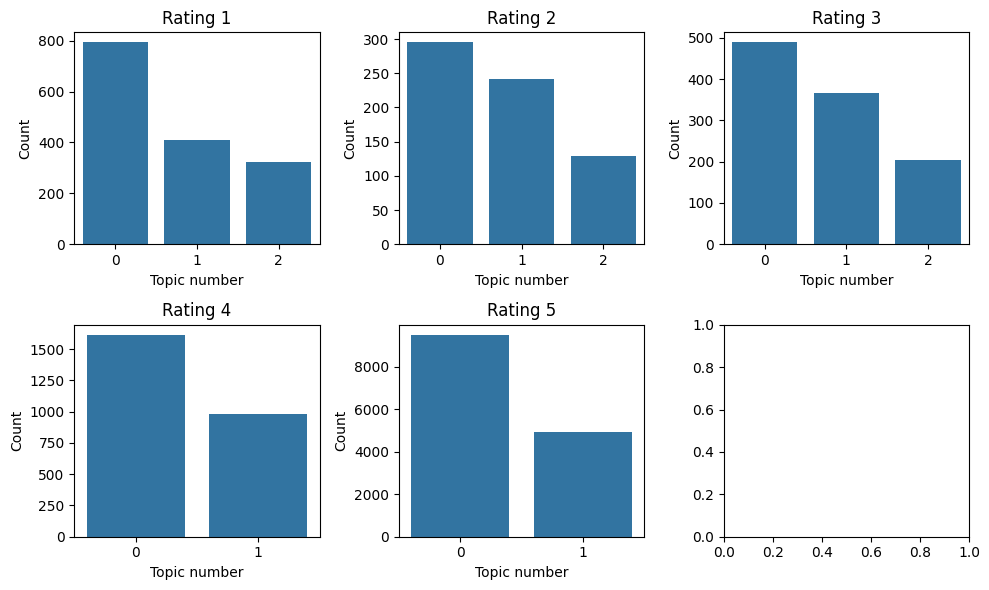

In [13]:
# visualize distribution of topics, one plot per rating arranged in grid with 2 rows and 3 columns
import seaborn as sns

# create grid of plots
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

# iterate over ratings and plot distribution of topics using count column
for i, rating in enumerate(range(1, 6)):
    ax = axs[i // 3, i % 3]
    sns.barplot(x='topic_number', y='count', data=df_topics[df_topics['star_rating'] == rating], ax=ax)
    ax.set_title(f'Rating {rating}')
    ax.set_xlabel('Topic number')
    ax.set_ylabel('Count')

# Display all subplots together
plt.tight_layout()
plt.show()

# generate phrases for topics

In [14]:
import os
from groq import Groq 

# Initialize the client
client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

# Define the system message
system_message = """
Generate a concise and coherent phrase that summarizes topics based on provided keywords
and associated review ratings. The keywords are ordered by relevance from the most to the least.

Ensure that each phrase accurately reflects the sentiment implied by the rating and highlights key aspects of the topic. 
For example, a rating of 1 should convey dissatisfaction or issues, while a rating of 5 should express satisfaction or positive feedback. 
Omit pronouns and conjunctions to keep the phrase succinct.

For reviews with low ratings (1-2) or with negative keywords, focus on problematic aspects such as defects, damages, or poor quality and 
be as detailed as possible.

Output only the phrase without additional commentary.

Example:

Input: "leak box, return, item, bottle leak, arrive damage, box, arrive, damage leak, damage, leak" Rating: 1
Output: "Leaking or damaged items and boxes upon delivery"
"""

def process_input(top_words, rating):
    user_message = f'Input: "{top_words}" rating: {rating}'
    response = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": system_message
            },
            {
                "role": "user",
                "content": user_message
            }
        ],
        model="llama3-8b-8192",
    )
    generated_phrase = response.choices[0].message.content
    return generated_phrase

# generate phrases for each topic in df_topics and add generated phrase to new column 'phrase'
df_topics['phrase'] = df_topics.apply(lambda x: process_input(x['topic_words'], x['star_rating']), axis=1)
df_topics

,star_rating,topic_number,count,topic_words,phrase
0,1.0,0,793,"[use, skin, formula, lotion, new, product, cha...","""New product does not live up to formula change"""
1,1.0,1,410,"[smell, scent, like, lotion, change, use, new,...","""Strong unpleasant scent on new lotion"""
2,1.0,2,322,"[pump, product, order, open, bottle, receive, ...","""Defective bottle pump not working after order..."
3,2.0,0,295,"[skin, lotion, use, dry, product, feel, like, ...",Dry skin not fully moisturized after using the...
4,2.0,1,242,"[smell, like, scent, lotion, just, good, vanil...","Strong vanilla scent, but just like lotion, no..."
5,2.0,2,129,"[pump, product, use, work, bottle, change, lot...",Good pump product with use issues
6,3.0,0,489,"[skin, lotion, use, dry, product, good, like, ...","""Dry skin improves with moisturizing lotion"""
7,3.0,1,366,"[smell, lotion, scent, like, skin, use, feel, ...","""Good scent and feel, but not remarkable fragr..."
8,3.0,2,204,"[product, pump, bottle, work, lotion, like, us...","""Pumps work, but not like expected for lotion"""
9,4.0,0,1614,"[skin, lotion, use, dry, product, feel, great,...",Dry skin product feels great.


In [15]:
# merge star_rating from df with labeled_reviews, drop review_text column
labeled_reviews = labeled_reviews.merge(df[['review_text', 'star_rating']], left_on='Document', right_on='review_text', how='left').drop(columns=['review_text'])
labeled_reviews

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document,star_rating
0,no retinol list on ingredient list,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[i have use this lotion for many year it use t...,use - skin - formula - lotion - new - product ...,False,1.0
1,same as everyone else… the change theyve make ...,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[i have use this lotion for many year it use t...,use - skin - formula - lotion - new - product ...,False,1.0
2,if youre look for something that smell good th...,1,1_smell_scent_like_lotion,"[smell, scent, like, lotion, change, use, new,...",[ive use this for year why do you change the s...,smell - scent - like - lotion - change - use -...,False,1.0
3,use this on my arm and leg have a strange text...,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[i have use this lotion for many year it use t...,use - skin - formula - lotion - new - product ...,False,1.0
4,i didnt get this because my shopper decide the...,2,2_pump_product_order_open,"[pump, product, order, open, bottle, receive, ...",[the pump doesnt work on the last two bottle i...,pump - product - order - open - bottle - recei...,False,1.0
...,...,...,...,...,...,...,...,...
20276,i feel this be one of the best lotion out ther...,0,0_skin_lotion_use_dry,"[skin, lotion, use, dry, product, love, feel, ...",[absolutely recommend to anyone with dry skin ...,skin - lotion - use - dry - product - love - f...,False,5.0
20277,love this lotion use it on a daily basis and i...,1,1_smell_love_scent_good,"[smell, love, scent, good, lotion, like, skin,...","[love the smell and how it feel, love love sme...",smell - love - scent - good - lotion - like - ...,False,5.0
20278,this lotion be one of the best lotion i have e...,1,1_smell_love_scent_good,"[smell, love, scent, good, lotion, like, skin,...","[love the smell and how it feel, love love sme...",smell - love - scent - good - lotion - like - ...,False,5.0
20279,i be in love with this lotion it make my skin ...,0,0_skin_lotion_use_dry,"[skin, lotion, use, dry, product, love, feel, ...",[absolutely recommend to anyone with dry skin ...,skin - lotion - use - dry - product - love - f...,False,5.0


In [18]:
# merge phrases with labeled_reviews
labeled_reviews = labeled_reviews.merge(df_topics[['star_rating', 'topic_number', 'phrase']], left_on=['Topic', 'star_rating'], right_on=['topic_number', 'star_rating'], how='left').drop(columns=['topic_number'])
labeled_reviews

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Representative_document,star_rating,phrase
0,no retinol list on ingredient list,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[i have use this lotion for many year it use t...,use - skin - formula - lotion - new - product ...,False,1.0,"""New product does not live up to formula change"""
1,same as everyone else… the change theyve make ...,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[i have use this lotion for many year it use t...,use - skin - formula - lotion - new - product ...,False,1.0,"""New product does not live up to formula change"""
2,if youre look for something that smell good th...,1,1_smell_scent_like_lotion,"[smell, scent, like, lotion, change, use, new,...",[ive use this for year why do you change the s...,smell - scent - like - lotion - change - use -...,False,1.0,"""Strong unpleasant scent on new lotion"""
3,use this on my arm and leg have a strange text...,0,0_use_skin_formula_lotion,"[use, skin, formula, lotion, new, product, cha...",[i have use this lotion for many year it use t...,use - skin - formula - lotion - new - product ...,False,1.0,"""New product does not live up to formula change"""
4,i didnt get this because my shopper decide the...,2,2_pump_product_order_open,"[pump, product, order, open, bottle, receive, ...",[the pump doesnt work on the last two bottle i...,pump - product - order - open - bottle - recei...,False,1.0,"""Defective bottle pump not working after order..."
...,...,...,...,...,...,...,...,...,...
20276,i feel this be one of the best lotion out ther...,0,0_skin_lotion_use_dry,"[skin, lotion, use, dry, product, love, feel, ...",[absolutely recommend to anyone with dry skin ...,skin - lotion - use - dry - product - love - f...,False,5.0,"""Warm, moisturized body with great product"""
20277,love this lotion use it on a daily basis and i...,1,1_smell_love_scent_good,"[smell, love, scent, good, lotion, like, skin,...","[love the smell and how it feel, love love sme...",smell - love - scent - good - lotion - like - ...,False,5.0,"""Lotion smelt good with a great product for lo..."
20278,this lotion be one of the best lotion i have e...,1,1_smell_love_scent_good,"[smell, love, scent, good, lotion, like, skin,...","[love the smell and how it feel, love love sme...",smell - love - scent - good - lotion - like - ...,False,5.0,"""Lotion smelt good with a great product for lo..."
20279,i be in love with this lotion it make my skin ...,0,0_skin_lotion_use_dry,"[skin, lotion, use, dry, product, love, feel, ...",[absolutely recommend to anyone with dry skin ...,skin - lotion - use - dry - product - love - f...,False,5.0,"""Warm, moisturized body with great product"""


# evaluate quality of generated phrases

In [16]:
# use sentence transformers to get similarity score between reviews and generated phrases
from sentence_transformers import SentenceTransformer
from torch.nn.functional import cosine_similarity

def similarity_scores(model_name, reviews, topics):
    """
    Calculate the similarity scores between reviews and topics using a pre-trained SentenceTransformer model.
    
    model_name: the name of the pre-trained SentenceTransformer model to use
    reviews: a list of review texts
    topics: a list of topic phrases
    
    return: a 2D numpy array of similarity scores
    """
    model = SentenceTransformer(model_name)
    review_embeddings = model.encode(reviews, convert_to_tensor=True)
    phrase_embeddings = model.encode(topics, convert_to_tensor=True)
    similarity_scores = cosine_similarity(review_embeddings, phrase_embeddings).cpu().numpy()
    return similarity_scores

In [19]:
import time

model = 'all-MiniLM-L6-v2'
reviews = labeled_reviews['Document'].tolist()
topics = labeled_reviews['phrase'].tolist()
# run similarity_scores on chunks of reviews 
chunk_size = 1000
n = labeled_reviews.shape[0]
similarity_scores_list = []
for i in range(0, n, chunk_size):
    print(f'Processing reviews {i} to {min(i+chunk_size, n)}')
    start = time.time()
    similarity_scores_list.extend(similarity_scores(model, reviews[i:i+chunk_size], topics[i:i+chunk_size]))
    end = time.time()
    print(f"Time taken: {end - start}")

labeled_reviews['similarity_score'] = similarity_scores_list

Processing reviews 0 to 1000
Time taken: 7.817329168319702
Processing reviews 1000 to 2000
Time taken: 6.477535963058472
Processing reviews 2000 to 3000
Time taken: 5.858871221542358
Processing reviews 3000 to 4000
Time taken: 5.342316627502441
Processing reviews 4000 to 5000
Time taken: 6.082520008087158
Processing reviews 5000 to 6000
Time taken: 6.370419263839722
Processing reviews 6000 to 7000
Time taken: 5.319131851196289
Processing reviews 7000 to 8000
Time taken: 4.428531169891357
Processing reviews 8000 to 9000
Time taken: 5.349736928939819
Processing reviews 9000 to 10000
Time taken: 4.660429000854492
Processing reviews 10000 to 11000
Time taken: 4.90881609916687
Processing reviews 11000 to 12000
Time taken: 3.6720478534698486
Processing reviews 12000 to 13000
Time taken: 5.7978880405426025
Processing reviews 13000 to 14000
Time taken: 4.3469743728637695
Processing reviews 14000 to 15000
Time taken: 4.388895750045776
Processing reviews 15000 to 16000
Time taken: 4.518725156784

took 1 min 48 sec to process 20,281 reviews

In [20]:
# print average similarity score for each rating/topic
avg_scores = labeled_reviews.groupby(['star_rating', 'Topic'])['similarity_score'].mean().reset_index()
avg_scores

,star_rating,Topic,similarity_score
0,1.0,0,0.292568
1,1.0,1,0.508198
2,1.0,2,0.233485
3,2.0,0,0.475186
4,2.0,1,0.516698
5,2.0,2,0.239777
6,3.0,0,0.516590
7,3.0,1,0.452190
8,3.0,2,0.298787
9,4.0,0,0.560048


In [22]:
# average similarity scores for each rating
avg_scores_per_rating = avg_scores.groupby('star_rating')['similarity_score'].mean().reset_index()
avg_scores_per_rating

,star_rating,similarity_score
0,1.0,0.344750
1,2.0,0.410554
2,3.0,0.422522
3,4.0,0.514557
4,5.0,0.383856


In [23]:
avg_scores['similarity_score'].mean()

np.float32(0.41002348)

_____previous results_____

,star_rating,Topic,similarity_score
0,1.0,0,0.292568
1,1.0,1,0.508198
2,1.0,2,0.233485
3,2.0,0,0.475186
4,2.0,1,0.516698
5,2.0,2,0.239777
6,3.0,0,0.516590
7,3.0,1,0.452190
8,3.0,2,0.298787
9,4.0,0,0.560048


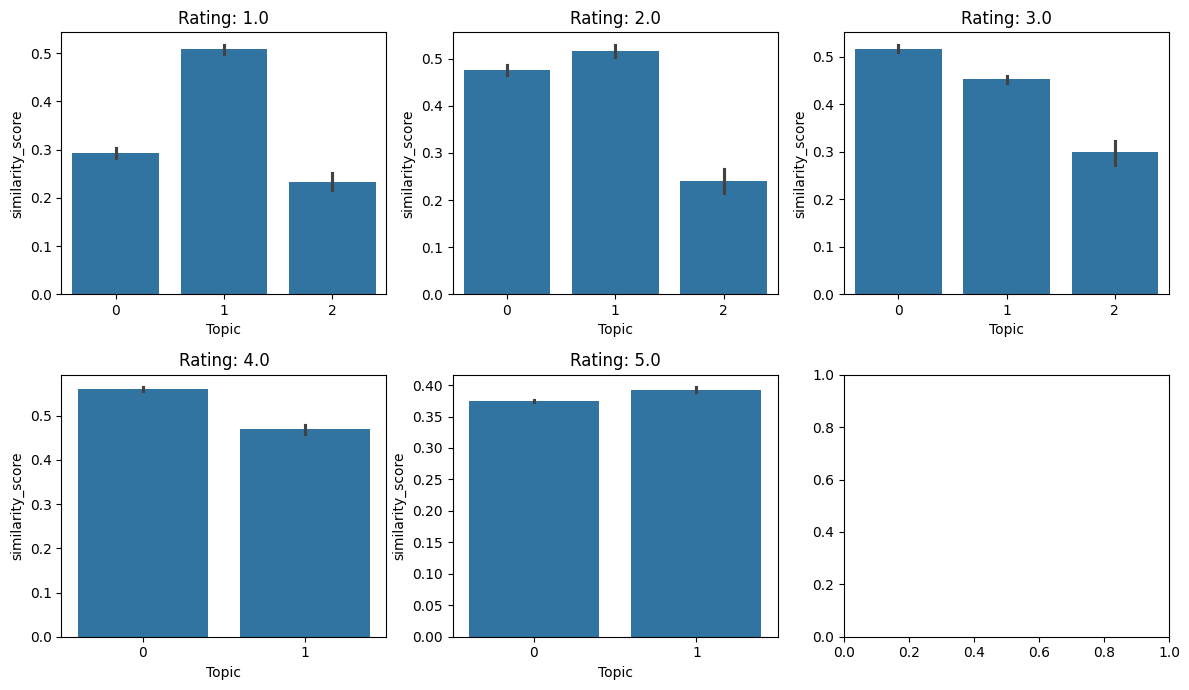

In [21]:
# print average similarity score for each rating/topic
avg_scores = labeled_reviews.groupby(['star_rating', 'Topic'])['similarity_score'].mean().reset_index()
# visualize average similarity scores for each rating/topic
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

for rating in labeled_reviews['star_rating'].unique():
    row = int((rating - 1) // 3)
    col = int((rating - 1) % 3)
    ax = axs[row][col]
    sns.barplot(data=labeled_reviews[labeled_reviews['star_rating'] == rating], x='Topic', y='similarity_score', ax=ax)
    ax.set_title(f"Rating: {rating}")
plt.tight_layout()
avg_scores

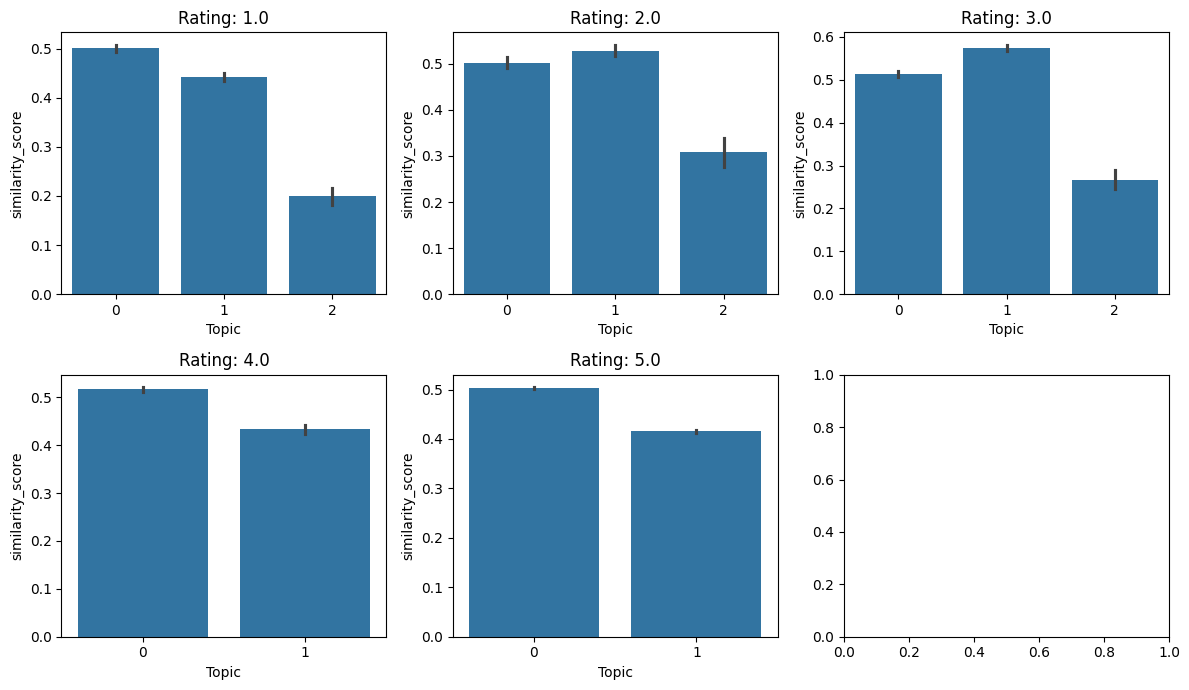

In [23]:
# visualize average similarity scores for each rating/topic
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

for rating in labeled_reviews['star_rating'].unique():
    row = int((rating - 1) // 3)
    col = int((rating - 1) % 3)
    ax = axs[row][col]
    sns.barplot(data=labeled_reviews[labeled_reviews['star_rating'] == rating], x='Topic', y='similarity_score', ax=ax)
    ax.set_title(f"Rating: {rating}")
plt.tight_layout()

In [24]:
# print all topic phrases
for i, row in df_topics.iterrows():
    print(f"{"-" * 100}\nRating: {row['star_rating']} Topic: {row['topic_number']} Phrase: {row['phrase']}\n")
    # print words for the topic
    print(row['topic_words'])

----------------------------------------------------------------------------------------------------
Rating: 1.0 Topic: 0 Phrase: Poor lotion formula leads to skin reaction

['use', 'skin', 'formula', 'lotion', 'new', 'product', 'change', 'year', 'old', 'buy']
----------------------------------------------------------------------------------------------------
Rating: 1.0 Topic: 1 Phrase: "Unpleasant smell, ineffective lotion formula."

['smell', 'scent', 'like', 'lotion', 'use', 'change', 'new', 'product', 'buy', 'formula']
----------------------------------------------------------------------------------------------------
Rating: 1.0 Topic: 2 Phrase: "Failed to open or receive faulty pumps and products"

['pump', 'product', 'order', 'open', 'bottle', 'receive', 'work', 'item', 'return', 'come']
----------------------------------------------------------------------------------------------------
Rating: 2.0 Topic: 0 Phrase: Dry skin after using lotion

['skin', 'lotion', 'use', 'dry', '

In [25]:
# keep Document, phrase, Topic, star_rating, Top_n_words, similarity_score, and standardize column names
to_save = labeled_reviews[['Document', 'phrase', 'Topic', 'star_rating', 'Top_n_words', 'similarity_score']]
to_save.columns = ['review_text', 'topic', 'topic_number', 'star_rating', 'topic_words', 'similarity_score']
to_save.to_csv(f'../outputs/bertopic_{label}_kmeans.csv', index=False)

In [26]:
# average similarity scores for each rating
avg_scores_per_rating = avg_scores.groupby('star_rating')['similarity_score'].mean().reset_index()
avg_scores_per_rating

,star_rating,similarity_score
0,1.0,0.380940
1,2.0,0.446646
2,3.0,0.451204
3,4.0,0.474606
4,5.0,0.459100


In [27]:
overall_avg_score = avg_scores['similarity_score'].mean()
overall_avg_score

np.float32(0.43875232)